In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import imageio

In [69]:
base_dir = Path("dataset/")
metadata = pd.read_csv(base_dir / "metadata.csv")
metadata.head()

,file_name,text
0,--Jiv5iYqT8_0.mp4,You know it'll swat you like a fly.
1,-1eKufUP5XQ_1.mp4,"Don't worry, as you can see I have this situat..."
2,-2KG4lLGEl0_3.mp4,on that Shelly. Don't get me wrong. Nostalgia'...
3,-2KGPYEFnsU_6.mp4,"I kinda gotta go home now, cause I have this S..."
4,-3KCgSpt3hU_0.mp4,in Thailand you believe that what one friend d...


In [4]:
mask_paths = [base_dir / "lip_masks/" / filename.replace(".mp4", "_mask.pt") for filename in metadata["file_name"].tolist()]

In [5]:
mask_paths[0]

PosixPath('dataset/lip_masks/--Jiv5iYqT8_0_mask.pt')

In [7]:
# Set threshold for minimum number of non-zero elements
threshold = 100  # Adjust this threshold as needed

# Lists to store paths and statistics
valid_paths = []
discard_paths = []
non_zero_counts = []
total_frames = []
non_zero_ratios = []

# Use multiprocessing to speed up processing
import multiprocessing as mp
from functools import partial

def process_tensor(tensor_path, threshold):
    try:
        # Use torch.load with map_location to control memory usage
        tensor = torch.load(str(tensor_path), map_location='cpu')
        
        # Get the count of non-zero elements
        non_zero_count = torch.count_nonzero(tensor).item()
        
        # Get total number of elements in the tensor
        total_frame_count = tensor.numel()
        
        # Calculate ratio of non-zero elements
        ratio = non_zero_count / total_frame_count if total_frame_count > 0 else 0
        
        # Check if count is below threshold
        is_valid = non_zero_count >= threshold
        
        # Free memory
        del tensor
        
        return {
            'path': tensor_path,
            'is_valid': is_valid,
            'non_zero_count': non_zero_count,
            'total_frame_count': total_frame_count,
            'ratio': ratio
        }
    except Exception as e:
        print(f"Error processing {tensor_path}: {e}")
        return {
            'path': tensor_path,
            'is_valid': False,
            'non_zero_count': 0,
            'total_frame_count': 0,
            'ratio': 0
        }

# Print progress
print(f"Processing {len(mask_paths)} mask files with {mp.cpu_count()} CPU cores...")

# Create a pool of workers
with mp.Pool(processes=mp.cpu_count()) as pool:
    # Process tensors in parallel with progress tracking
    results = []
    for i, result in enumerate(pool.imap(partial(process_tensor, threshold=threshold), mask_paths)):
        results.append(result)
        if i % 100 == 0:
            print(f"Processing {i} out of {len(mask_paths)}")

# Organize results
for result in results:
    if result['is_valid']:
        valid_paths.append(result['path'])
    else:
        discard_paths.append(result['path'])
    
    non_zero_counts.append(result['non_zero_count'])
    total_frames.append(result['total_frame_count'])
    non_zero_ratios.append(result['ratio'])

# Print statistics
print(f"Total mask files: {len(mask_paths)}")
print(f"Valid mask files: {len(valid_paths)}")
print(f"Discarded mask files: {len(discard_paths)}")
print(f"Average non-zero elements: {np.mean(non_zero_counts):.2f}")
print(f"Median non-zero elements: {np.median(non_zero_counts):.2f}")
print(f"Min non-zero elements: {min(non_zero_counts) if non_zero_counts else 0}")
print(f"Max non-zero elements: {max(non_zero_counts) if non_zero_counts else 0}")
print(f"Average non-zero ratio: {np.mean(non_zero_ratios):.4f}")


Processing 28764 mask files with 48 CPU cores...


Processing 0 out of 28764
Processing 100 out of 28764
Processing 200 out of 28764
Processing 300 out of 28764
Processing 400 out of 28764
Processing 500 out of 28764
Error processing dataset/lip_masks/BDvjjQvM498_0_mask.pt: [Errno 2] No such file or directory: 'dataset/lip_masks/BDvjjQvM498_0_mask.pt'
Processing 600 out of 28764
Processing 700 out of 28764
Processing 800 out of 28764
Processing 900 out of 28764
Processing 1000 out of 28764
Processing 1100 out of 28764
Processing 1200 out of 28764
Processing 1300 out of 28764
Processing 1400 out of 28764
Processing 1500 out of 28764
Processing 1600 out of 28764
Processing 1700 out of 28764
Processing 1800 out of 28764
Processing 1900 out of 28764
Processing 2000 out of 28764
Processing 2100 out of 28764
Processing 2200 out of 28764
Processing 2300 out of 28764
Processing 2400 out of 28764
Processing 2500 out of 28764
Processing 2600 out of 28764
Processing 2700 out of 28764
Processing 2800 out of 28764
Processing 2900 out of 28764
Proce

In [63]:
discard_df = pd.DataFrame({"file_name": [path.name.replace("_mask.pt", ".mp4") for path in discard_paths]})
discard_df.to_csv(base_dir /"discard_masks.csv", index=False)

In [70]:
# filter original metadata.csv to remove discard_df
metadata_filtered = metadata[~metadata["file_name"].isin(discard_df["file_name"])]

In [72]:
metadata_filtered.to_csv(base_dir / "filtered_metadata.csv", index=False)

In [60]:
# Load the video using a video reader instead of imread
import cv2
video_path = str(base_dir / "train" / discard_df["file_name"][40].replace("_mask.pt", ".mp4"))
cap = cv2.VideoCapture(video_path)
ret, first_frame = cap.read()
if ret:
    # Convert BGR to RGB
    first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
else:
    print(f"Failed to read video: {video_path}")
    first_frame = np.zeros((256, 256, 3), dtype=np.uint8)  # Placeholder
cap.release()

# Load the mask
mask_path = str(base_dir / "lip_masks" / discard_df["file_name"][100])
load_mask = torch.load(mask_path).cpu().numpy().squeeze()[0]

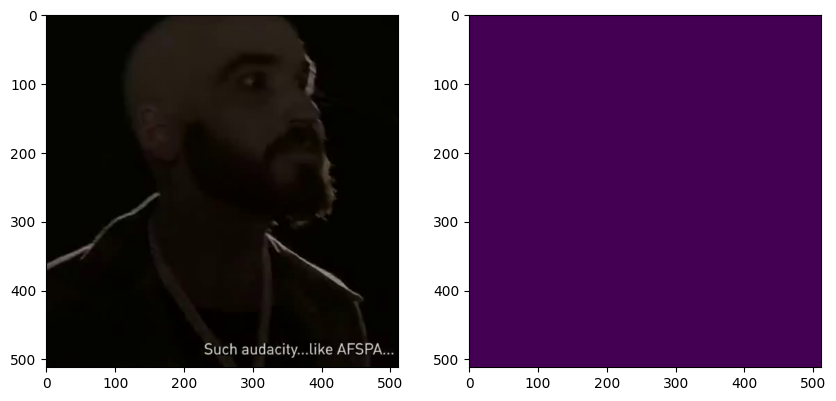

In [61]:
# Visualize discarded mask and original image side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))


axes[0].imshow(first_frame)
axes[1].imshow(load_mask)
plt.show()


In [ ]:
for tensor_path in mask_paths:
    tensors = torch.load(tensor_path)
